 # Handwritten Digit Classification

## <div> Vassilis Panagakis </div>

## Overview




### MNIST Dataset

* **train-images.idx3-ubyte** - training set images (60000 examples)
* **train-labels.idx1-ubyte** - training set labels
* **t10k-images.idx3-ubyte** - test set images (10000 examples)
* **t10k-labels.idx1-ubyte** - test set labels

```
TRAINING SET IMAGE FILE (train-images.idx3-ubyte)

[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel

Pixels are organized row-wise. Pixel values are 0 to 255. 
0 means background (white), 255 means foreground (black).
```
```
TRAINING SET LABEL FILE (train-labels.idx1-ubyte)

[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label

The labels values are 0 to 9.
```
```
TEST SET IMAGE FILE (t10k-images.idx3-ubyte)

[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  10000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel

Pixels are organized row-wise. Pixel values are 0 to 255. 
0 means background (white), 255 means foreground (black).
```
```
TEST SET LABEL FILE (t10k-labels.idx1-ubyte)

[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  10000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label

The labels values are 0 to 9.
```

### Task

The purpose of this project is to predict correctly as many as possible handwritten digits of  MNIST's test set (`t10k-images.idx3-ubyte`). <br>
In order to achieve that we will build a complex Neural Network as follows:

1. Create and train an Autoencoder Neural Νetwork.
 
2. Create and train a Classifier (Feed-Forward Neural Network), using the encoder part of the Autoencoder.

3. Evaluate the Classifier's accuracy based on the provided labels of the test set (`t10k-labels.idx1-ubyte`).

## Libraries

In [1]:
#!/usr/bin/python

import sys, getopt
import struct
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

## Load Data

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
general_path = 'gdrive/My Drive/Colab Notebooks/image processing/Data'
print(list(os.listdir(f'{general_path}')))

['train-images.idx3-ubyte', 'train-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte']


## Figures Functions

In [10]:
from matplotlib import ticker 

# Function to plot the loss-epochs figure for current model
def dispLossEpoch(loss, val_loss): 
    epochs_r = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs_r, val_loss, label='Validation loss')
    plt.plot(epochs_r, loss, label='Training loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

# Function to plot the accuracy-epochs figure for current model
def dispAccuracyEpoch(accuracy, val_accuracy): 
    epochs_r = range(1, len(accuracy) + 1)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    ax.plot(epochs_r, val_accuracy, label='Validation accuracy')
    ax.plot(epochs_r, accuracy, label='Training accuracy')
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
    
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.legend()
    plt.show()

# Function to plot summary figures of models tested so far
def dispSummFigs(modelsFcSize, modelsEpochs, modelsBatchSizes, modelsTrainLosses, modelsValLosses, modelsTrainAccuracy, modelsValAccuracy): 
    # modelsFcSize - modelsTrainLosses / modelsFcSize - modelsValLosses 
    plt.figure()
    plt.title('Summary of tested models: Training and validation loss')

    x, y = zip(*sorted(zip(modelsFcSize, modelsValLosses)))
    plt.plot(x, y, ':o', label='Validation loss')

    x, y = zip(*sorted(zip(modelsFcSize, modelsTrainLosses)))
    plt.plot(x, y, ':o', label='Training loss')

    plt.xlabel('Fully Connected Layer Size')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

    # modelsFcSize - modelsTrainAccuracy / modelsFcSize - modelsValAccuracy
    plt.figure()
    plt.title('Summary of tested models: Training and validation accuracy')

    x, y = zip(*sorted(zip(modelsFcSize, modelsValAccuracy)))
    plt.plot(x, y, ':o', label='Validation accuracy')

    x, y = zip(*sorted(zip(modelsFcSize, modelsTrainAccuracy)))
    plt.plot(x, y, ':o', label='Training accuracy')

    plt.xlabel('Fully Connected Layer Size')
    plt.ylabel('Accuracy')

    plt.legend()
    plt.show()

    # modelsEpochs - modelsTrainLosses / modelsEpochs - modelsValLosses
    plt.figure()
    plt.title('Summary of tested models: Training and validation loss')

    x, y = zip(*sorted(zip(modelsEpochs, modelsValLosses)))
    plt.plot(x, y, ':o', label='Validation loss')

    x, y = zip(*sorted(zip(modelsEpochs, modelsTrainLosses)))
    plt.plot(x, y, ':o', label='Training loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

    # modelsEpochs - modelsTrainAccuracy / modelsEpochs - modelsValAccuracy
    plt.figure()
    plt.title('Summary of tested models: Training and validation accuracy')

    x, y = zip(*sorted(zip(modelsEpochs, modelsValAccuracy)))
    plt.plot(x, y, ':o', label='Validation accuracy')

    x, y = zip(*sorted(zip(modelsEpochs, modelsTrainAccuracy)))
    plt.plot(x, y, ':o', label='Training accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.legend()
    plt.show()

    # modelsBatchSizes - modelsTrainLosses / modelsBatchSizes - modelsValLosses
    plt.figure()
    plt.title('Summary of tested models: Training and validation loss')

    x, y = zip(*sorted(zip(modelsBatchSizes, modelsValLosses)))
    plt.plot(x, y, ':o', label='Validation loss')

    x, y = zip(*sorted(zip(modelsBatchSizes, modelsTrainLosses)))
    plt.plot(x, y, ':o', label='Training loss')

    plt.xlabel('Batch size')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

    # modelsBatchSizes - modelsTrainAccuracy / modelsBatchSizes - modelsValAccuracy
    plt.figure()
    plt.title('Summary of tested models: Training and validation accuracy')

    x, y = zip(*sorted(zip(modelsBatchSizes, modelsValAccuracy)))
    plt.plot(x, y, ':o', label='Validation accuracy')

    x, y = zip(*sorted(zip(modelsBatchSizes, modelsTrainAccuracy)))
    plt.plot(x, y, ':o', label='Training accuracy')

    plt.xlabel('Batch size')
    plt.ylabel('Accuracy')

    plt.legend()
    plt.show()

## Autoencoder Implementation

In [5]:
# Read a 32-bit little endian integer from a binary file and convert it to big endian integer
def inputInfo(f): 

    if f.tell() > 12:
        return -1

    leNum = struct.unpack('i', f.read(4))[0] # Get integer in little endian format

    # Do the proper shifts
    b0 = (leNum & 0x000000ff) << 24
    b1 = (leNum & 0x0000ff00) << 8
    b2 = (leNum & 0x00ff0000) >> 8
    b3 = (leNum & 0xff000000) >> 24

    beNum = b0 | b1 | b2 | b3 # Reconstruct integer in big endian format

    return beNum

# Function to implement the encoder part of the Autoencoder
def encoder(input_img, numOfLayers, kernel, filters, activations): 
    conv = input_img
    for i in range(numOfLayers):
        if filters[i] != -1: # Conv layer
            conv = Conv2D(filters[i], (kernel, kernel), activation=activations[i], padding='same')(conv)
            conv = BatchNormalization()(conv)

        else: # Max Pooling layer
            conv = MaxPooling2D(pool_size=(2, 2))(conv)

    return conv

# Function to implement the decoder part of the Autoencoder
def decoder(encoded, numOfLayers, kernel, filters, activations, lastActivation): 
    conv = encoded
    for i in range(numOfLayers -1, -1, -1):
        if filters[i] != -1: # Conv layer
            conv = Conv2D(filters[i], (kernel, kernel), activation=activations[i], padding='same')(conv)
            conv = BatchNormalization()(conv)

        else: # Up Sampling layer
            conv = UpSampling2D((2,2))(conv)

    decoded = Conv2D(1, (kernel, kernel), activation=lastActivation, padding='same')(conv) # 28 x 28 x 1

    return decoded

## Autoencoder Training

In [6]:
pathX_train = f'{general_path}/train-images.idx3-ubyte' 

try:
    ftr = open(pathX_train, "rb")
except OSError:
    print ('Cannot open binary file')

ftr.seek(4)   # Ignore magic number

numOfImages = inputInfo(ftr)    # Get number of images from binary file
rows = inputInfo(ftr)           # Get number of rows from binary file
cols = inputInfo(ftr)           # Get number of columns from binary file

if (numOfImages == -1) or (rows == -1) or (cols == -1):
    print ("A wrong part of the file was read")
    sys.exit(1)

imageSize = rows * cols

pixels = ftr.read(numOfImages * imageSize) # Read all pixels
pixSplit = [pixels[i] for i in range (0, len(pixels))] # Split pixel by pixel

ftr.close()


images = np.array(pixSplit) # Make np array with pixels
images = images.reshape((numOfImages, rows, cols)) # Reshape to numOfImages images of rows x cols dimension

normalized_images = images / max(pixels) # Normalization from [0, max_pixel] to [0, 1]

# Parameters
batchSize = 64
kernel = 3
epochs = 40
numOfLayers = 7
filters = [32, 32, -1, 64, -1, 128, 256]
activations = ['relu', 'relu', '', 'relu', '', 'relu', 'relu']
lastActivation = 'sigmoid'
input_img = Input(shape = (rows, cols, 1)) # Construct the format of the input image

autoencoder = Model(input_img, decoder(encoder(input_img, numOfLayers, kernel, filters, activations), numOfLayers, kernel, filters, activations, lastActivation))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

Im_train, Im_val = train_test_split(normalized_images, test_size=0.2, random_state=13)
autoencoder_train = autoencoder.fit(Im_train, Im_train, batch_size=batchSize, epochs=epochs, verbose=1, validation_data=(Im_val, Im_val), callbacks=[early_stopping])

loss = autoencoder_train.history['loss'] # loss history lists
val_loss = autoencoder_train.history['val_loss'] # val_loss history lists

autoencoder.save('gdrive/My Drive/Colab Notebooks/image processing/autoencoder.h5') # Save the autoencoder model to use for classification    

Epoch 1/40
750/750 [==============================] - 47s 19ms/step - loss: 0.0127 - val_loss: 0.0070
Epoch 2/40
750/750 [==============================] - 14s 18ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 3/40
750/750 [==============================] - 14s 18ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 4/40
750/750 [==============================] - 14s 18ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/40
750/750 [==============================] - 14s 18ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/40
750/750 [==============================] - 14s 19ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 7/40
750/750 [==============================] - 14s 19ms/step - loss: 0.0011 - val_loss: 8.8831e-04
Epoch 8/40
750/750 [==============================] - 14s 19ms/step - loss: 9.5954e-04 - val_loss: 0.0011
Epoch 9/40
750/750 [==============================] - 14s 19ms/step - loss: 8.7421e-04 - val_loss: 8.3131e-04
Epoch 10/40
750/750 [==============================] - 14s 19ms/st

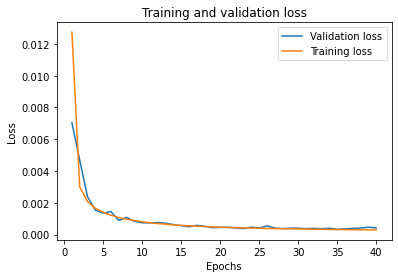

In [7]:
# Display loss figure
dispLossEpoch(loss, val_loss)

## Classifier Implementation & Training

In [8]:
pathX_train = f'{general_path}/train-images.idx3-ubyte' 
pathY_train = f'{general_path}/train-labels.idx1-ubyte'
pathX_test = f'{general_path}/t10k-images.idx3-ubyte'
pathY_test = f'{general_path}/t10k-labels.idx1-ubyte'
pathAutoencoder = 'gdrive/My Drive/Colab Notebooks/image processing/autoencoder.h5'

# X_train file
try:
    fX = open(pathX_train, "rb")
except OSError:
    print('Cannot open binary file')

fX.seek(4)   # Ignore magic number

numOfImages = inputInfo(fX)    # Get number of images from binary file
rows = inputInfo(fX)           # Get number of rows from binary file
cols = inputInfo(fX)           # Get number of columns from binary file

if (numOfImages == -1) or (rows == -1) or (cols == -1):
    print("A wrong part of the file was read")
    sys.exit(1)

imageSize = rows * cols

pixels = fX.read(numOfImages * imageSize) # Read all pixels
pixSplit = [pixels[i] for i in range (0, len(pixels))] # Split pixel by pixel

fX.close()

trainImages = np.array(pixSplit) # Make np array with pixels
trainImages = trainImages.reshape((numOfImages, rows, cols)) # Reshape to numOfImages images of rows x cols dimension

trainImages = trainImages / max(pixels) # Normalization from [0, max_pixel] to [0, 1]


# X_test file
try:
    fX = open(pathX_test, "rb")
except OSError:
    print('Cannot open binary file')

fX.seek(4)   # Ignore magic number

numOfImages = inputInfo(fX)    # Get number of images from binary file
rows = inputInfo(fX)           # Get number of rows from binary file
cols = inputInfo(fX)           # Get number of columns from binary file

if (numOfImages == -1) or (rows == -1) or (cols == -1):
    print("A wrong part of the file was read")
    sys.exit(1)

imageSize = rows * cols

pixels = fX.read(numOfImages * imageSize) # Read all pixels
pixSplit = [pixels[i] for i in range (0, len(pixels))] # Split pixel by pixel

fX.close()

testImages = np.array(pixSplit) # Make np array with pixels
testImages = testImages.reshape((numOfImages, rows, cols)) # Reshape to numOfImages images of rows x cols dimension

testImages = testImages / max(pixels) # Normalization from [0, max_pixel] to [0, 1]

# Y_train file
try:
    fY = open(pathY_train, "rb")
except OSError:
    print('Cannot open binary file')

fY.seek(4)   # Ignore magic number

numOfLabels = inputInfo(fY)    # Get number of labels from binary file

if numOfLabels == -1:
    print("A wrong part of the file was read")
    sys.exit(1)

labels = fY.read(numOfLabels) # Read all pixels
labelsSplit = [labels[i] for i in range (0, len(labels))] # Split pixel by pixel

fY.close()

trainLabels = np.array(labelsSplit) # Make np array with pixels

# Y_test file
try:
    fY = open(pathY_test, "rb")
except OSError:
    print('Cannot open binary file')

fY.seek(4)   # Ignore magic number

numOfLabels = inputInfo(fY)    # Get number of labels from binary file

if numOfLabels == -1:
    print("A wrong part of the file was read")
    sys.exit(1)

labels = fY.read(numOfLabels) # Read all pixels
labelsSplit = [labels[i] for i in range (0, len(labels))] # Split pixel by pixel

fY.close()

testLabels = np.array(labelsSplit) # Make np array with pixels

numOfClasses = 10 # 0-9 labels

# Change the labels from categorical to one-hot encoding
trainLabelsOneHot = to_categorical(trainLabels)
testLabelsOneHot = to_categorical(testLabels)

autoencoder = load_model(pathAutoencoder) # Load saved autoencoder model
encoder = Model(autoencoder.input, autoencoder.layers[(len(autoencoder.layers) // 2) - 1].output) # Get only the encoder layers of aytoencoder

numOfExecs = 0 # Number of training executions 

modelsTrainLosses = [] # Training losses
modelsValLosses = [] # Validation losses

modelsTrainAccuracy = [] # Training accuracy
modelsValAccuracy = [] # Validation accuracy    

modelsFcSize = [] # Fully connected layer size
modelsEpochs = [] # Epochs trained
modelsBatchSizes = [] # Batch sizes

while True:

    if numOfExecs > 0:
        repeat = input("Do you want to repeat the experiment for a different model? (Y) or (N)\n")
        if (repeat == 'N') or (repeat == 'n'):
            break
        print()

    def_exec = input("Do you want to use the default hyperparameters? (Y) or (N)\n")

    if (def_exec == 'Y') or (def_exec == 'y'): # Option to use default hyperparameteres (best hyperparameteres after experimentation) 
        batchSize = 256
        epochs = 100
        fcSize = 128
        fcActivation = 'relu'
        lastActivation = 'softmax'

    else:   # Option to use user-given hyperparameteres 
        epochs = int(input("Give number of epochs per train: "))
        batchSize = int(input("Give batch size: "))
        fcSize = int(input("Give Fully Connected layer's size: "))

        if fcSize < 1 or batchSize < 1 or epochs < 1:
            print('Wrong hyperparameteres given')
            sys.exit(2)

        fcActivation = input("Give the activation function of the Fully Connected layer: ")                                
        lastActivation = input("Give the activation function of the output layer: ")

    # Classifier
    enc = encoder.output # Encoder's layers are classifier's inputs
    flat = Flatten()(enc) # Flatten encoder's last layer
    den = Dense(fcSize, activation=fcActivation)(flat) # Add dense hidden layer
    out = Dense(numOfClasses, activation=lastActivation)(den) # Dense output layer 

    classifier = Model(inputs=encoder.inputs, outputs=out)
    trainImages, valImages, trainLabelsOneHot, valLabelsOneHot = train_test_split(trainImages, trainLabelsOneHot, test_size=0.2, random_state=13)

    early_stopping = EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=20,
        restore_best_weights=True,
    )

    for layer in classifier.layers[0 : (len(encoder.layers))]: # At first, we only train the Fully Connected part of the Classifier
        layer.trainable = False

    classifier.compile(loss='categorical_crossentropy', optimizer = Adam(), metrics=['accuracy'])
    classifier_train1 = classifier.fit(trainImages, trainLabelsOneHot, batch_size=batchSize, epochs=epochs, verbose=1, validation_data=(valImages, valLabelsOneHot))

    for layer in classifier.layers[0 : (len(encoder.layers))]: # Next, we train the whole Classifier
        layer.trainable = True

    classifier.compile(loss='categorical_crossentropy', optimizer = Adam(), metrics=['accuracy'])
    classifier_train2 = classifier.fit(trainImages, trainLabelsOneHot, batch_size=batchSize, epochs=epochs, verbose=1, validation_data=(valImages, valLabelsOneHot), callbacks=[early_stopping])
    
    loss = classifier_train1.history['loss'] + classifier_train2.history['loss'] # Concatenate loss history lists
    val_loss = classifier_train1.history['val_loss'] + classifier_train2.history['val_loss'] # Concatenate val_loss history lists
    
    accuracy = classifier_train1.history['accuracy'] + classifier_train2.history['accuracy'] # Concatenate accuracy history lists
    val_accuracy = classifier_train1.history['val_accuracy'] + classifier_train2.history['val_accuracy'] # Concatenate val_accuracy history 

    numOfExecs += 1 # Raise number of executions flag

    modelsTrainLosses.append(loss[-1:]) # Final training loss
    modelsValLosses.append(val_loss[-1:]) # Final validation loss

    modelsTrainAccuracy.append(accuracy[-1:]) # Final training accuracy
    modelsValAccuracy.append(val_accuracy[-1:]) # Final validation accuracy

    modelsFcSize.append(fcSize) # Fully connected layer size
    modelsEpochs.append(len(loss)) # Epochs trained
    modelsBatchSizes.append(batchSize) # Batch sizes

Do you want to use the default hyperparameters? (Y) or (N)
y
Epoch 1/100
188/188 [==============================] - 3s 13ms/step - loss: 0.2474 - accuracy: 0.9351 - val_loss: 0.1036 - val_accuracy: 0.9702
Epoch 2/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0449 - accuracy: 0.9861 - val_loss: 0.0854 - val_accuracy: 0.9751
Epoch 3/100
188/188 [==============================] - 2s 12ms/step - loss: 0.0199 - accuracy: 0.9941 - val_loss: 0.0835 - val_accuracy: 0.9771
Epoch 4/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0087 - accuracy: 0.9976 - val_loss: 0.0759 - val_accuracy: 0.9801
Epoch 5/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.0746 - val_accuracy: 0.9814
Epoch 6/100
188/188 [==============================] - 2s 11ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0791 - val_accuracy: 0.9807
Epoch 7/100
188/188 [==============================] - 2s 11ms/step - loss:

## Classifier Evaluation 

### Figures

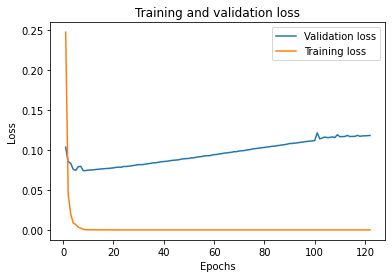

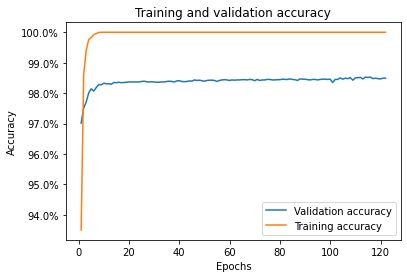

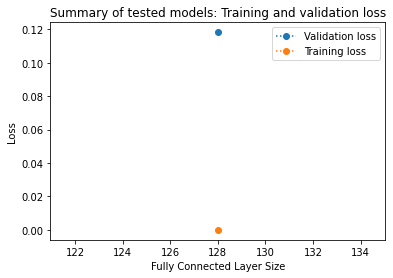

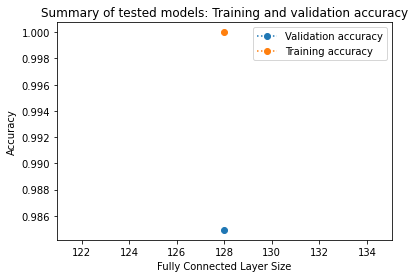

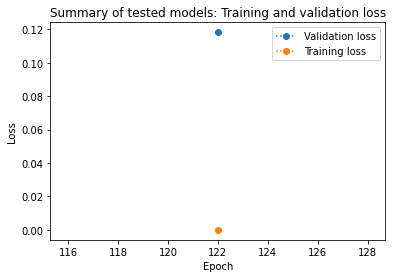

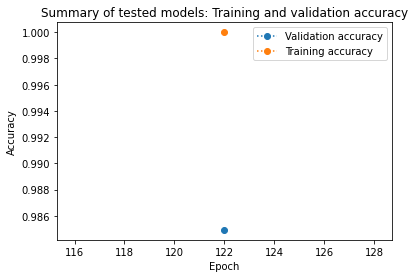

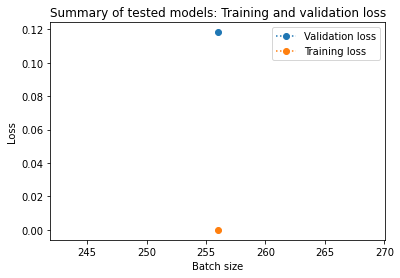

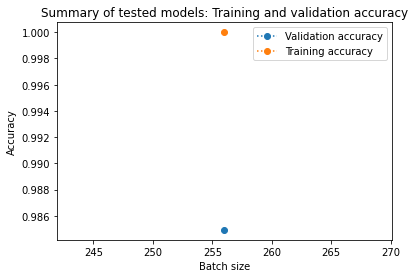

In [11]:
dispLossEpoch(loss, val_loss)
dispAccuracyEpoch(accuracy, val_accuracy)

if (len(modelsValLosses) > 0) and (len(modelsValAccuracy) > 0):
  dispSummFigs(modelsFcSize, modelsEpochs, modelsBatchSizes, modelsTrainLosses, modelsValLosses, modelsTrainAccuracy, modelsValAccuracy)

### Loss & Accuracy

In [ ]:
# Evaluate classifier's performance on test set
testEval = classifier.evaluate(testImages, testLabelsOneHot, verbose=0) 

print('Test loss: {:.4f}'.format(testEval[0]))
print('Test accuracy: {:.2%}'.format(testEval[1]))

Test loss: 0.0903
Test accuracy: 98.67%


### Classification Report

In [ ]:
predClasses = classifier.predict(testImages) # Predict on test set
predClasses = np.argmax(np.round(predClasses), axis=1)

correct = np.where(predClasses == testLabels)[0] # Calculate correctly predicted labels
incorrect = np.where(predClasses != testLabels)[0] # Calculate incorrectly predicted labels

print("Found %d correct labels" % len(correct))
print("Found %d incorrect labels\n" % len(incorrect))

target = ["Class {}".format(i) for i in range(numOfClasses)]
print(classification_report(testLabels, predClasses, target_names=target))

Found 9867 correct labels
Found 133 incorrect labels

              precision    recall  f1-score   support

     Class 0       0.98      0.99      0.99       980
     Class 1       1.00      1.00      1.00      1135
     Class 2       0.99      0.98      0.98      1032
     Class 3       0.98      0.99      0.99      1010
     Class 4       0.98      0.99      0.99       982
     Class 5       0.99      0.99      0.99       892
     Class 6       0.99      0.99      0.99       958
     Class 7       0.99      0.98      0.98      1028
     Class 8       0.98      0.98      0.98       974
     Class 9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### Correctly predicted digits

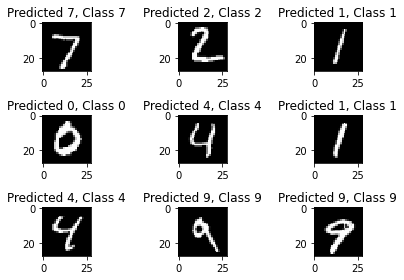

In [ ]:
correct = np.where(predClasses == testLabels)[0] # Calculate correctly predicted labels

# Plot correctly predicted digits
for i, correct in enumerate(correct[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(testImages[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predClasses[correct], testLabels[correct]))
    plt.tight_layout()
plt.show()

### Incorrectly predicted digits

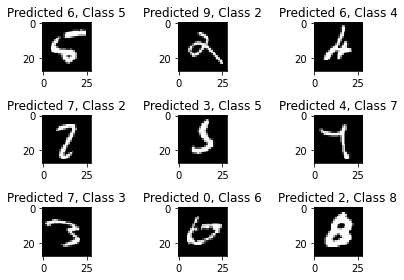

In [ ]:
incorrect = np.where(predClasses != testLabels)[0] # Calculate incorrectly predicted labels

# Plot incorrectly predicted digits
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(testImages[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predClasses[incorrect], testLabels[incorrect]))
    plt.tight_layout()
plt.show()